# Libraries

In [10]:
import torch
import os
import random
import nltk
import heapq
import time
import math
import subprocess
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, RegexpTokenizer

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data Preparation

In [12]:
# File paths
eng_dev_path = '/kaggle/input/nlp-dataset/eng_Latn.dev'
eng_devtest_path = '/kaggle/input/nlp-dataset/eng_Latn.devtest'
urd_dev_path = '/kaggle/input/nlp-dataset/urd_Arab.dev'
urd_devtest_path = '/kaggle/input/nlp-dataset/urd_Arab.devtest'

# Function to read lines from a file
def read_lines(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    return lines

# Read English sentences
eng_dev = read_lines(eng_dev_path)
eng_devtest = read_lines(eng_devtest_path)

# Read Urdu sentences
urd_dev = read_lines(urd_dev_path)
urd_devtest = read_lines(urd_devtest_path)

### Combining dev and devtest data

In [13]:
# Combine English sentences
eng_sentences = eng_dev + eng_devtest

# Combine Urdu sentences
urd_sentences = urd_dev + urd_devtest

### Sentences Pairing

In [14]:
# Check if the number of sentences matches
assert len(eng_sentences) == len(urd_sentences), "The number of English and Urdu sentences do not match!"

# Print the number of sentences
print(f"Total number of sentence pairs: {len(eng_sentences)}")
print(f"Total number of sentence pairs: {len(urd_sentences)}")

Total number of sentence pairs: 2009
Total number of sentence pairs: 2009


In [15]:
# Create a list of tuples (urdu_sentence, eng_sentence)
data = list(zip(urd_sentences, eng_sentences))

### Random shuffle of data

In [16]:
# Set a random seed for reproducibility
random_seed = 42
random.seed(random_seed)

# Shuffle the data
random.shuffle(data)

### Data splitting

In [17]:
# Calculate split indices
total_samples = len(data)
train_size = int(0.7 * total_samples)
valid_size = int(0.15 * total_samples)
test_size = total_samples - train_size - valid_size  # Ensure all data is used

# Split the data
train_data = data[:train_size]
valid_data = data[train_size:train_size + valid_size]
test_data = data[train_size + valid_size:]

# Verify the splits
print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(valid_data)}")
print(f"Test samples: {len(test_data)}")

Training samples: 1406
Validation samples: 301
Test samples: 302


In [18]:
# Function to separate sources and targets
def separate_sources_targets(data_split):
    urdu_sentences = [pair[0].strip() for pair in data_split]
    eng_sentences = [pair[1].strip() for pair in data_split]
    return urdu_sentences, eng_sentences

# Training set
train_urdu, train_eng = separate_sources_targets(train_data)

# Validation set
valid_urdu, valid_eng = separate_sources_targets(valid_data)

# Test set
test_urdu, test_eng = separate_sources_targets(test_data)

### Tokenization

In [19]:
# Download the necessary NLTK data files
nltk.download('punkt')

# Tokenization function for English sentences
def tokenize_sentence_english(sentence):
    return word_tokenize(sentence, language='english')

# Tokenization function for Urdu sentences
def tokenize_sentence_urdu(sentence):
    # Define a regex pattern to match Urdu words and punctuation
    # Urdu characters are in the Unicode range \u0600-\u06FF
    pattern = r'[\u0600-\u06FF]+|[^\u0600-\u06FF\s]'
    tokenizer = RegexpTokenizer(pattern)
    return tokenizer.tokenize(sentence)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [20]:
# Check lengths
assert len(train_urdu) == len(train_eng), "Training Urdu and English sets do not match in length."
assert len(valid_urdu) == len(valid_eng), "Validation Urdu and English sets do not match in length."
assert len(test_urdu) == len(test_eng), "Test Urdu and English sets do not match in length."

# Example of a training pair
print("Example training pair:")
print(f"Urdu: {train_urdu[0]}")
print(f"English: {train_eng[0]}")

Example training pair:
Urdu: 7 اکتوبر کو اڑان بھرتے ہی انجن طیارہ سے جدا ہو گیا لیکن کوئی اتلاف نہیں ہوا۔ اس حادثہ کے بعد روس نے آئی ایل-76 طیاروں کو خدمت سے برطرف کردیا۔
English: On October 7 an engine separated on takeoff, without injuries. Russia briefly grounded Il-76s after that accident.


# Data Preprocessing

### Vocabulary Building

In [21]:
# Special tokens
PAD_token = 0  # Padding token
SOS_token = 1  # Start-of-sequence token
EOS_token = 2  # End-of-sequence token
UNK_token = 3  # Unknown words token

In [22]:
class Vocabulary:
    def __init__(self):
        self.word2index = { "<PAD>": PAD_token, "<SOS>": SOS_token, "<EOS>": EOS_token, "<UNK>": UNK_token }
        self.word2count = {}
        self.index2word = {PAD_token: "<PAD>", SOS_token: "<SOS>", EOS_token: "<EOS>", UNK_token: "<UNK>"}
        self.n_words = 4  # Count PAD, SOS, EOS, UNK

    def add_sentence(self, sentence, language='english'):
        tokens = tokenize_sentence_english(sentence) if language == 'english' else tokenize_sentence_urdu(sentence)
        for word in tokens:
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    def sentence_to_indices(self, sentence, language='english'):
        tokens = tokenize_sentence_english(sentence) if language == 'english' else tokenize_sentence_urdu(sentence)
        return [self.word2index.get(word, self.word2index["<UNK>"]) for word in tokens] + [EOS_token]

In [23]:
# Initialize vocabularies
urdu_vocab = Vocabulary()
eng_vocab = Vocabulary()

# Build vocabularies
for sentence in train_urdu:
    urdu_vocab.add_sentence(sentence)
for sentence in train_eng:
    eng_vocab.add_sentence(sentence)

print(f"Urdu vocabulary size: {urdu_vocab.n_words}")
print(f"English vocabulary size: {eng_vocab.n_words}")

Urdu vocabulary size: 7840
English vocabulary size: 7625


### Sentences to tensors

In [24]:
# Convert sentences to tensors
def sentence_to_tensor(vocab, sentence):
    indices = vocab.sentence_to_indices(sentence)
    return torch.tensor(indices, dtype=torch.long, device=device).view(-1, 1)

def pair_to_tensors(urdu_sentence, eng_sentence):
    input_tensor = sentence_to_tensor(urdu_vocab, urdu_sentence)
    target_tensor = sentence_to_tensor(eng_vocab, eng_sentence)
    return input_tensor, target_tensor

In [25]:
# Convert training data to tensors
train_tensors = [pair_to_tensors(urdu, eng) for urdu, eng in zip(train_urdu, train_eng)]
valid_tensors = [pair_to_tensors(urdu, eng) for urdu, eng in zip(valid_urdu, valid_eng)]
test_tensors = [pair_to_tensors(urdu, eng) for urdu, eng in zip(test_urdu, test_eng)]

# Example of tensor conversion
print("Example of tensor conversion:")
print(f"Urdu sentence: {train_urdu[0]}")
print(f"Urdu tensor: {train_tensors[0][0]}")
print(f"English sentence: {train_eng[0]}")
print(f"English tensor: {train_tensors[0][1]}")

Example of tensor conversion:
Urdu sentence: 7 اکتوبر کو اڑان بھرتے ہی انجن طیارہ سے جدا ہو گیا لیکن کوئی اتلاف نہیں ہوا۔ اس حادثہ کے بعد روس نے آئی ایل-76 طیاروں کو خدمت سے برطرف کردیا۔
Urdu tensor: tensor([[ 4],
        [ 5],
        [ 6],
        [ 7],
        [ 8],
        [ 9],
        [10],
        [11],
        [12],
        [13],
        [14],
        [15],
        [16],
        [17],
        [18],
        [19],
        [20],
        [21],
        [22],
        [23],
        [24],
        [25],
        [26],
        [27],
        [28],
        [29],
        [ 6],
        [30],
        [12],
        [31],
        [32],
        [ 2]], device='cuda:0')
English sentence: On October 7 an engine separated on takeoff, without injuries. Russia briefly grounded Il-76s after that accident.
English tensor: tensor([[ 4],
        [ 5],
        [ 6],
        [ 7],
        [ 8],
        [ 9],
        [10],
        [11],
        [12],
        [13],
        [14],
        [15],
        [16],
   

# Model Design

In [26]:
MAX_LENGTH = max(len(sentence.split()) for sentence in train_urdu + train_eng) + 5

## Custom LSTM Cell

In [27]:
class CustomLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Input gate layers
        self.W_i = nn.Linear(input_size, hidden_size)
        self.U_i = nn.Linear(hidden_size, hidden_size, bias=False)

        # Forget gate layers
        self.W_f = nn.Linear(input_size, hidden_size)
        self.U_f = nn.Linear(hidden_size, hidden_size, bias=False)

        # Cell gate layers
        self.W_g = nn.Linear(input_size, hidden_size)
        self.U_g = nn.Linear(hidden_size, hidden_size, bias=False)

        # Output gate layers
        self.W_o = nn.Linear(input_size, hidden_size)
        self.U_o = nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, x, hidden, cell):
        # x: (batch_size, input_size)
        # hidden: (batch_size, hidden_size)
        # cell: (batch_size, hidden_size)

        i = torch.sigmoid(self.W_i(x) + self.U_i(hidden))
        f = torch.sigmoid(self.W_f(x) + self.U_f(hidden))
        g = torch.tanh(self.W_g(x) + self.U_g(hidden))
        o = torch.sigmoid(self.W_o(x) + self.U_o(hidden))

        cell_new = f * cell + i * g
        hidden_new = o * torch.tanh(cell_new)

        return hidden_new, cell_new

## Custom Encoder LSTM

In [28]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, embedding_size=256):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.lstm_cell = CustomLSTMCell(embedding_size, hidden_size)

    def forward(self, input_seq, hidden, cell):
        # input_seq: (seq_len, batch_size)
        # hidden, cell: (batch_size, hidden_size)
        embedded = self.embedding(input_seq).squeeze(1)  # (batch_size, embedding_size)
        hidden, cell = self.lstm_cell(embedded, hidden, cell)
        return hidden, cell

    def init_hidden(self, batch_size=1):
        return torch.zeros(batch_size, self.hidden_size, device=device)

    def init_cell(self, batch_size=1):
        return torch.zeros(batch_size, self.hidden_size, device=device)

## Custom Decoder LSTM with Attention

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionDecoderLSTM(nn.Module):
    def __init__(self, hidden_size, output_size, embedding_size=256, dropout_p=0.1):
        super(AttentionDecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding_size = embedding_size
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(output_size, embedding_size)
        self.dropout = nn.Dropout(self.dropout_p)

        # Additive (Bahdanau) Attention layers
        self.attn = nn.Linear(self.hidden_size + self.embedding_size, self.hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))

        # Linear layer to project combined embeddings back to embedding_size
        self.combined_linear = nn.Linear(self.embedding_size + self.hidden_size, self.embedding_size)

        self.lstm_cell = CustomLSTMCell(embedding_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input_step, hidden, cell, encoder_outputs, input_length):
        # input_step: (batch_size, 1)
        # hidden: (batch_size, hidden_size)
        # cell: (batch_size, hidden_size)
        # encoder_outputs: (seq_len, batch_size, hidden_size)
        embedded = self.embedding(input_step).squeeze(1)  # (batch_size, embedding_size)
        embedded = self.dropout(embedded)

        # Compute attention scores
        seq_len = input_length
        encoder_outputs = encoder_outputs[:seq_len]  # (seq_len, batch_size, hidden_size)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # (batch_size, seq_len, hidden_size)

        hidden_expand = hidden.unsqueeze(1).repeat(1, seq_len, 1)  # (batch_size, seq_len, hidden_size)
        energy = torch.tanh(self.attn(torch.cat((embedded.unsqueeze(1).repeat(1, seq_len, 1), hidden_expand), dim=2)))  # (batch_size, seq_len, hidden_size)
        energy = energy.permute(0, 2, 1)  # (batch_size, hidden_size, seq_len)
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)  # (batch_size, 1, hidden_size)
        attn_weights = torch.bmm(v, energy).squeeze(1)  # (batch_size, seq_len)
        attn_weights = F.softmax(attn_weights, dim=1)  # (batch_size, seq_len)

        # Compute context vector
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)  # (batch_size, hidden_size)

        # Combine embedded input and context
        combined = torch.cat((embedded, context), dim=1)  # (batch_size, embedding_size + hidden_size)
        combined = torch.tanh(combined)  # (batch_size, embedding_size + hidden_size)
        combined = self.combined_linear(combined)  # (batch_size, embedding_size)

        # Pass through LSTM cell
        hidden, cell = self.lstm_cell(combined, hidden, cell)  # (batch_size, hidden_size), (batch_size, hidden_size)

        # Generate output
        output = self.out(hidden)  # (batch_size, output_size)
        output = F.log_softmax(output, dim=1)  # (batch_size, output_size)

        return output, hidden, cell, attn_weights

# Training and Evaluation

In [30]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH, teacher_forcing_ratio=0.5):
    input_tensor = input_tensor.to(device)
    target_tensor = target_tensor.to(device)

    batch_size = input_tensor.size(1)  # (seq_len, batch_size)

    encoder_hidden = encoder.init_hidden(batch_size)
    encoder_cell = encoder.init_cell(batch_size)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, batch_size, encoder.hidden_size, device=device)

    loss = 0

    # Encoder forward pass
    for ei in range(input_length):
        encoder_hidden, encoder_cell = encoder(input_tensor[ei], encoder_hidden, encoder_cell)
        encoder_outputs[ei] = encoder_hidden

    # Decoder initial states
    decoder_input = torch.tensor([SOS_token] * batch_size, device=device)  # (batch_size)
    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell, _ = decoder(
                decoder_input.unsqueeze(1),  # (batch_size, 1)
                decoder_hidden,
                decoder_cell,
                encoder_outputs,
                input_length
            )
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell, _ = decoder(
                decoder_input.unsqueeze(1),  # (batch_size, 1)
                decoder_hidden,
                decoder_cell,
                encoder_outputs,
                input_length
            )
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze(1).detach()  # Ensure decoder_input has shape (batch_size,)

            loss += criterion(decoder_output, target_tensor[di])
            if torch.all(decoder_input == EOS_token):
                break

    loss.backward()

    torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1)  # Gradient clipping
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1)

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


### Beam Search Decoding

In [31]:
class Beam:
    def __init__(self, tokens, log_prob, hidden, cell):
        self.tokens = tokens            # List of token indices
        self.log_prob = log_prob        # Cumulative log-probability
        self.hidden = hidden            # Hidden state tensor
        self.cell = cell                # Cell state tensor

    def __lt__(self, other):
        return self.log_prob < other.log_prob

In [32]:
def evaluate_beam(encoder, decoder, sentence, beam_width=3, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = sentence_to_tensor(urdu_vocab, sentence)
        input_length = input_tensor.size()[0]
        batch_size = input_tensor.size(1)  
        encoder_hidden = encoder.init_hidden(batch_size)
        encoder_cell = encoder.init_cell(batch_size)

        # Initialize encoder_outputs with the correct dimensions
        encoder_outputs = torch.zeros(max_length, batch_size, encoder.hidden_size, device=device)

        # Encoder forward pass
        for ei in range(input_length):
            encoder_hidden, encoder_cell = encoder(input_tensor[ei], encoder_hidden, encoder_cell)
            encoder_outputs[ei] = encoder_hidden

        # Initialize the beam with the start token
        initial_beam = Beam(tokens=[SOS_token], log_prob=0.0, hidden=encoder_hidden, cell=encoder_cell)
        beams = [initial_beam]
        completed_beams = []

        for _ in range(max_length):
            all_candidates = []
            for beam in beams:
                # If the last token is EOS, add the beam to completed_beams
                if beam.tokens[-1] == EOS_token:
                    completed_beams.append(beam)
                    continue

                # Prepare decoder input (last token)
                decoder_input = torch.tensor([[beam.tokens[-1]]], device=device)  # (1, 1)

                # Pass through decoder with input_length
                decoder_output, decoder_hidden, decoder_cell, attn_weights = decoder(
                    decoder_input, beam.hidden, beam.cell, encoder_outputs, input_length
                )

                # Get top beam_width predictions
                topv, topi = decoder_output.topk(beam_width)
                topv = topv.squeeze(0)    # (beam_width,)
                topi = topi.squeeze(0)    # (beam_width,)

                for i in range(beam_width):
                    token = topi[i].item()
                    log_prob = beam.log_prob + topv[i].item()
                    candidate = Beam(
                        tokens=beam.tokens + [token],
                        log_prob=log_prob,
                        hidden=decoder_hidden,
                        cell=decoder_cell
                    )
                    all_candidates.append(candidate)

            # If no candidates are left (all beams have completed), break
            if not all_candidates:
                break

            # Select top beam_width beams
            ordered = sorted(all_candidates, key=lambda x: x.log_prob, reverse=True)
            beams = ordered[:beam_width]

        # Add any remaining beams to completed_beams
        completed_beams.extend(beams)

        # Select the beam with the highest log_prob
        best_beam = max(completed_beams, key=lambda x: x.log_prob)

        # Convert tokens to words
        decoded_words = [eng_vocab.index2word.get(token, "<UNK>") for token in best_beam.tokens[1:]]  # Exclude SOS
        # Remove tokens after EOS
        if '<EOS>' in decoded_words:
            decoded_words = decoded_words[:decoded_words.index('<EOS>')]

        return decoded_words

### Training Loop

In [33]:
# Helper functions for time tracking
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {s:.0f}s'

def time_since(since, percent):
    now = time.time()
    elapsed = now - since
    if percent > 0:
        estimated = elapsed / percent
    else:
        estimated = 0
    remaining = estimated - elapsed
    return f'{as_minutes(elapsed)} (- {as_minutes(remaining)})'

# Training Iterations
def train_iters(encoder, decoder, n_iters, print_every=1000, bleu_every=5000, learning_rate=0.001):
    start = time.time()
    plot_losses = []
    plot_bleu_train = []
    plot_bleu_valid = []
    print_loss_total = 0  # Reset every print_every

    encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss(ignore_index=PAD_token)

    training_pairs = [random.choice(train_tensors) for _ in range(n_iters)]

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]  # (seq_len, 1)
        target_tensor = training_pair[1]  # (target_len, 1)

        # Schedule teacher forcing: linearly decrease from 1.0 to 0.0
        teacher_forcing_ratio = max(1.0 - iter / n_iters, 0.0)

        loss = train(
            input_tensor, 
            target_tensor, 
            encoder, 
            decoder, 
            encoder_optimizer, 
            decoder_optimizer, 
            criterion, 
            teacher_forcing_ratio=teacher_forcing_ratio
        )
        print_loss_total += loss

        # Print and evaluate loss every print_every iterations
        if iter % print_every == 0:
            elapsed = time.time() - start
            percent = iter / n_iters
            eta = time_since(start, percent)
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0

            print(f'Iter: {iter}/{n_iters} ({percent * 100:.2f}%) | '
              f'Elapsed: {as_minutes(elapsed)} | '
              f'ETA: {eta} | '
              f'Avg Loss: {print_loss_avg:.4f}')

        # Compute BLEU scores every bleu_every iterations
        if iter % bleu_every == 0:
            # Compute BLEU scores on training and validation sets
            bleu_train = calculate_bleu(
                encoder, 
                decoder, 
                list(zip(train_urdu, train_eng)),  
                beam_width=4, 
                max_length=MAX_LENGTH
            )
            bleu_valid = calculate_bleu(
                encoder, 
                decoder, 
                list(zip(valid_urdu, valid_eng)), 
                beam_width=4, 
                max_length=MAX_LENGTH
            )

            plot_losses.append(print_loss_avg)
            plot_bleu_train.append(bleu_train)
            plot_bleu_valid.append(bleu_valid)

            print(f'BLEU Train: {bleu_train:.4f} BLEU Valid: {bleu_valid:.4f}')

    # Plot Loss
    plt.figure()
    plt.plot(plot_losses, label='Training Loss')
    plt.xlabel('Evaluation Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.show()

    # Plot BLEU Scores
    plt.figure()
    plt.plot(plot_bleu_train, label='BLEU Train')
    plt.plot(plot_bleu_valid, label='BLEU Valid')
    plt.xlabel('Evaluation Steps')
    plt.ylabel('BLEU Score')
    plt.title('BLEU Scores')
    plt.legend()
    plt.show()

    return plot_bleu_train, plot_bleu_valid

### Evaluation

In [34]:
def evaluate_randomly_beam(encoder, decoder, n=10, beam_width=3):
    for _ in range(n):
        pair = random.choice(valid_data)
        print('Urdu:', pair[0].strip())
        print('Expected English:', pair[1].strip())
        output_words = evaluate_beam(encoder, decoder, pair[0], beam_width=beam_width)
        output_sentence = ' '.join(output_words)
        print('Predicted English:', output_sentence)
        print()

# Evaluate the set for BLEU score
def calculate_bleu(encoder, decoder, test_data, beam_width=3, max_length=MAX_LENGTH):
    references = []
    hypotheses = []

    for urdu_sentence, eng_sentence in test_data:
        references.append([eng_sentence.strip().split()])
        # Using evaluate_beam to generate output words
        output_words = evaluate_beam(encoder, decoder, urdu_sentence.strip(), beam_width, max_length)
        hypotheses.append(output_words[:-1])  # Exclude <EOS> token if present

    # Write predictions and references to files
    predictions_path = "/kaggle/working/predictions.txt"
    references_path = "/kaggle/working/references.txt"

    with open(predictions_path, "w", encoding="utf-8") as pred_file:
        for sentence in hypotheses:
            pred_file.write(" ".join(sentence) + "\n")

    with open(references_path, "w", encoding="utf-8") as ref_file:
        for sentence in references:
            ref_file.write(" ".join(sentence[0]) + "\n")

    # Call Moses multi-bleu script
    perl_script_path = "/kaggle/input/moses-script/multi-bleu.perl"
    bleu_output = subprocess.run(
        ["perl", perl_script_path, references_path],
        stdin=open(predictions_path, "r", encoding="utf-8"),
        text=True,
        capture_output=True
    )

    print("BLEU score:", bleu_output.stdout.strip())

    # Extract BLEU score
    try:
        bleu_score_str = bleu_output.stdout.strip().split()[2].replace(",", "")
        bleu_score = float(bleu_score_str)
    except (IndexError, ValueError):
        bleu_score = 0.0

    return bleu_score

### Execution

In [35]:
hidden_size = 256
encoder = EncoderLSTM(urdu_vocab.n_words, hidden_size).to(device)
decoder = AttentionDecoderLSTM(hidden_size, eng_vocab.n_words, dropout_p=0.1).to(device)

Iter: 1000/20000 (5.00%) | Elapsed: 2m 2s | ETA: 2m 2s (- 38m 35s) | Avg Loss: 6.6873
Iter: 2000/20000 (10.00%) | Elapsed: 4m 2s | ETA: 4m 2s (- 36m 19s) | Avg Loss: 5.9371
Iter: 3000/20000 (15.00%) | Elapsed: 6m 3s | ETA: 6m 3s (- 34m 17s) | Avg Loss: 5.4540
Iter: 4000/20000 (20.00%) | Elapsed: 8m 1s | ETA: 8m 1s (- 32m 5s) | Avg Loss: 5.0825
Iter: 5000/20000 (25.00%) | Elapsed: 10m 1s | ETA: 10m 1s (- 30m 3s) | Avg Loss: 4.6733
Iter: 6000/20000 (30.00%) | Elapsed: 12m 1s | ETA: 12m 1s (- 28m 1s) | Avg Loss: 4.4461
Iter: 7000/20000 (35.00%) | Elapsed: 13m 59s | ETA: 13m 59s (- 25m 58s) | Avg Loss: 4.2916
Iter: 8000/20000 (40.00%) | Elapsed: 15m 55s | ETA: 15m 55s (- 23m 53s) | Avg Loss: 3.9355
Iter: 9000/20000 (45.00%) | Elapsed: 17m 52s | ETA: 17m 52s (- 21m 50s) | Avg Loss: 3.8876
Iter: 10000/20000 (50.00%) | Elapsed: 19m 48s | ETA: 19m 48s (- 19m 48s) | Avg Loss: 3.7538
BLEU score: BLEU = 8.72, 35.0/15.2/9.8/6.9 (BP=0.631, ratio=0.685, hyp_len=20698, ref_len=30218)
BLEU score: BLEU

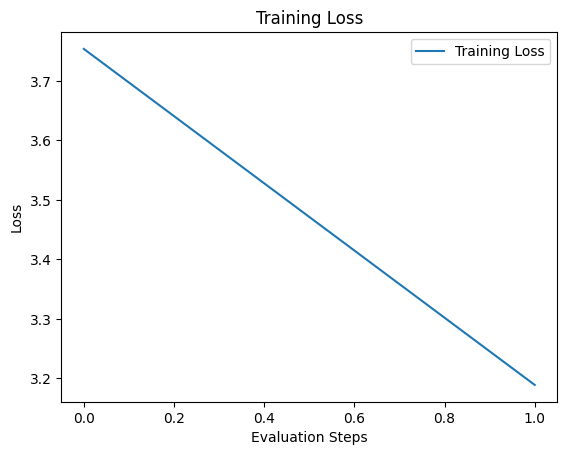

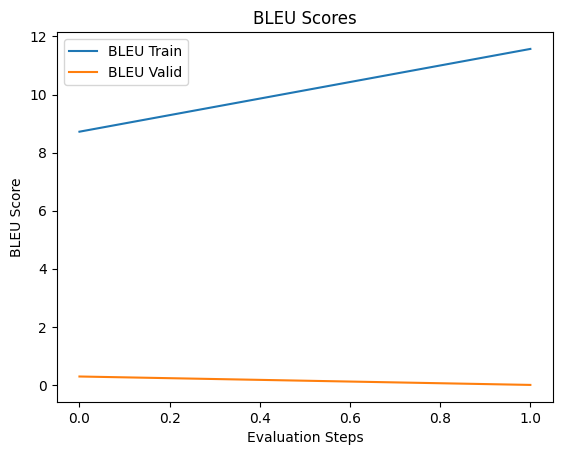

In [36]:
plot_bleu_train, plot_bleu_valid = train_iters(encoder, decoder, n_iters=20000, print_every=1000, bleu_every=10000)

## Sentence Translation (Prediction)

In [37]:
evaluate_randomly_beam(encoder, decoder, n=5, beam_width=4)

Urdu: سنسکرت ایک قدیم زبان ہے جس کا مقابلہ یورپ میں بولی جانے والی لاطینی زبان سے ہوتا ہے۔
Expected English: Sanskrit is an ancient language and is comparable to the Latin language spoken in Europe.
Predicted English: The pyramid sound is is south is south is a is is in in in a

Urdu: پھر، چند سالوں کے بعد، سن 1639 میں،جرمیاہ ہورکس نامی انگریز ماہر فلکیات نے زہرہ کی نقل و حرکت کا مشاہدہ کیا۔
Expected English: Then, a few years later in 1639, an English astronomer named Jeremiah Horrocks observed a transit of Venus.
Predicted English: They looked the rooms on rooms , the the the the the the the the the

Urdu: اندرونی زہر خورانی ممکن ہے کہ فوری طور پر ظاہر نہ ہو۔ متلی جیسے علامات اتنی عام ہیں کہ فوری تشخیص ممکن نہیں۔
Expected English: Internal poisoning may not be immediately apparent. Symptoms, such as vomiting are sufficiently general that an immediate diagnosis cannot be made.
Predicted English: Because , , , , , , , , , , a ,

Urdu: اس میں ویٹنگ لائن بھی ہوتی ہے، اس لئے کہ بغیر کسی ا

## Final bleu score (on test set)

BLEU score: BLEU = 0.00, 11.6/0.5/0.0/0.0 (BP=0.845, ratio=0.856, hyp_len=5456, ref_len=6373)
Final BLEU score on Test Set: 0.0000


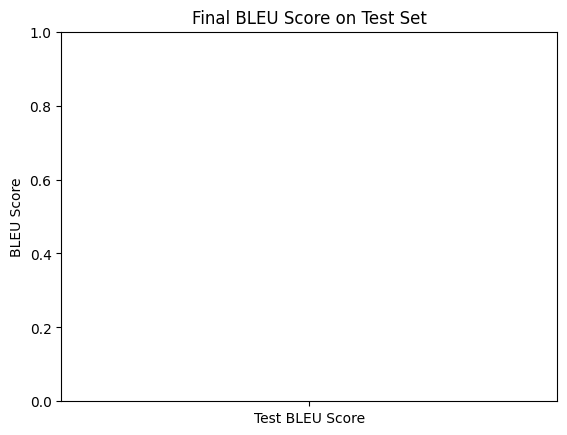

In [38]:
final_bleu_test = calculate_bleu(encoder, decoder, test_data, beam_width=4, max_length=MAX_LENGTH)
print(f'Final BLEU score on Test Set: {final_bleu_test:.4f}')

# Plot the final BLEU score
plt.figure()
plt.bar(['Test BLEU Score'], [final_bleu_test], color='skyblue')
plt.ylim(0, 1)
plt.ylabel('BLEU Score')
plt.title('Final BLEU Score on Test Set')
plt.show()

## Comparative Results

In [39]:
# Function to create and display the comparative results table
def create_comparative_table(bleu_train, bleu_valid, bleu_test):
    data = {
        'Dataset': ['Train (Subset)', 'Validation', 'Test'],
        'BLEU Score': [bleu_train, bleu_valid, bleu_test]
    }
    
    # Create a DataFrame
    df = pd.DataFrame(data)
    
    # Display the table
    print(df)
    
    # Plot the table using matplotlib
    fig, ax = plt.subplots(figsize=(6, 2))  
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)
    plt.title('Comparative BLEU Scores on Datasets', fontsize=14)
    plt.show()

          Dataset  BLEU Score
0  Train (Subset)       11.57
1      Validation        0.00
2            Test        0.00


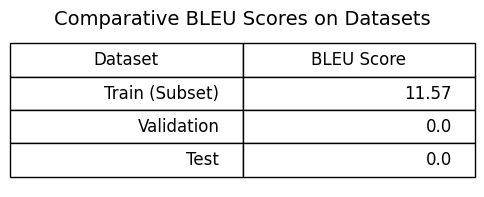

In [40]:
final_bleu_train = plot_bleu_train[-1] if plot_bleu_train else 0.0
final_bleu_valid = plot_bleu_valid[-1] if plot_bleu_valid else 0.0

# Create and display the comparative table
create_comparative_table(final_bleu_train, final_bleu_valid, final_bleu_test)